<a href="https://colab.research.google.com/github/dipsikhamudoi/Case-Study--Lead-Scoring/blob/main/Gesture_Recognition_Case_Study_Dipsikha.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Gesture Recognition


**Problem Statement**

Imagine you are working as a data scientist at a home electronics company which manufactures state of the art smart televisions. You want to develop a cool feature in the smart-TV that can recognise five different gestures performed by the user which will help users control the TV without using a remote. 

In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. 

Each gesture corresponds to a specific command:
 
| Gesture | Corresponding Action |
| --- | --- | 
| Thumbs Up | Increase the volume. |
| Thumbs Down | Decrease the volume. |
| Left Swipe | 'Jump' backwards 10 seconds. |
| Right Swipe | 'Jump' forward 10 seconds. |
| Stop | Pause the movie. |






In [2]:
#mount colab zip file
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [31]:
#Extract Data
!unzip '/gdrive/MyDrive/Project_data.zip' -d '/gdrive/MyDrive/Project_data'


Streaming output truncated to the last 5000 lines.
 extracting: /gdrive/MyDrive/Project_data/Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_20180926_17_34_37_Pro_00050.png  
 extracting: /gdrive/MyDrive/Project_data/Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_20180926_17_34_37_Pro_00052.png  
 extracting: /gdrive/MyDrive/Project_data/Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_20180926_17_34_37_Pro_00054.png  
 extracting: /gdrive/MyDrive/Project_data/Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_20180926_17_34_37_Pro_00056.png  
 extracting: /gdrive/MyDrive/Project_data/Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_20180926_17_34_37_Pro_00058.png  
 extracting: /gdrive/MyDrive/Project_data/Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_20180926_17_34_37_Pro_00060.png  
 extracting: /gdrive/MyDrive/Project_data/Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_20180926_17_34_37_Pro_00062.png  
   creating

In [4]:
# Import Libraries
import numpy as np
import os
from skimage.transform import resize
from imageio import imread
import datetime
import os
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

We set the random seed so that the results don't vary drastically.

In [5]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [6]:
train_doc = np.random.permutation(open('/gdrive/MyDrive/Project_data/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/gdrive/MyDrive/Project_data/Project_data/val.csv').readlines())
batch_size = 50

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [7]:
def cropResize(image, y, z):
    h, w = image.shape
    
    # if smaller image crop at center for 120x120
    if w == 160:
        image = image[:120, 20:140]

    # resize every image
    return resize(image, (y,z))

In [8]:
def normalizeImage(image):
    # applying normalization
    return image/255.0

In [9]:
def preprocessImage(image, y, z):
    return normalizeImage(cropResize(image, y, z))

In [10]:
def make3dFilter(x):
    return tuple([x]*3)

def make2dFilter(x):
    return tuple([x]*2)

In [11]:
def getBatchData(source_path, t, batch, batch_size, img_tensor):
    [x,y,z] = [len(img_tensor[0]),img_tensor[1], img_tensor[2]]
    img_idx = img_tensor[0]
    batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
    batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
    for folder in range(batch_size): # iterate over the batch_size
        imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
        for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
            image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)

            #crop the images and resize them. Note that the images are of 2 different shape 
            #and the conv3D will throw error if the inputs in a batch have different shapes

            # separate preprocessImage function is defined for cropping, resizing and normalizing images
            batch_data[folder,idx,:,:,0] = preprocessImage(image[:, :, 0], y, z)
            batch_data[folder,idx,:,:,1] = preprocessImage(image[:, :, 1], y, z)
            batch_data[folder,idx,:,:,2] = preprocessImage(image[:, :, 2], y, z)

        batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
    return batch_data, batch_labels

In [12]:
def generator(source_path, folder_list, batch_size, img_tensor):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    while True:
        t = np.random.permutation(folder_list)
        num_batches = int(len(folder_list)/batch_size)
        for batch in range(num_batches): # we iterate over the number of batches
            yield getBatchData(source_path, t, batch, batch_size, img_tensor)
        
        # write the code for the remaining data points which are left after full batches
        # checking if any remaining batches are there or not
        if len(folder_list)%batch_size != 0:
            # updated the batch size and yield
            batch_size = len(folder_list)%batch_size
            yield getBatchData(source_path, t, batch, batch_size, img_tensor)

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [13]:
curr_dt_time = datetime.datetime.now()
train_path = '/gdrive/MyDrive/Project_data/Project_data/train'
val_path = '/gdrive/MyDrive/Project_data/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 10
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 10


In [14]:
def getImgTensor(n_frames):
    img_idx = np.round(np.linspace(0, 29, n_frames)).astype(int)
    return [img_idx, 100, 100, 3]

# define image tensor size
img_tensor = getImgTensor(20)
print ('# img_tensor =', img_tensor)

# img_tensor = [array([ 0,  2,  3,  5,  6,  8,  9, 11, 12, 14, 15, 17, 18, 20, 21, 23, 24,
       26, 27, 29]), 100, 100, 3]


### Generator Validation

In [15]:
# check complete batch shape
sample_generator = generator(train_path, train_doc, batch_size, img_tensor)
sample_batch_data, sample_batch_labels = next(sample_generator)
print(sample_batch_data.shape)

# validation batch sample
sample_val_generator = generator(val_path, val_doc, batch_size, img_tensor)
sample_val_batch_data, sample_val_batch_labels = next(sample_val_generator)
print(sample_val_batch_data.shape)

Source path =  /gdrive/MyDrive/Project_data/Project_data/train ; batch size = 50
(50, 20, 100, 100, 3)
Source path =  /gdrive/MyDrive/Project_data/Project_data/val ; batch size = 50
(50, 20, 100, 100, 3)


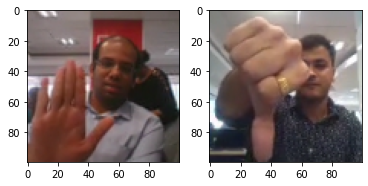

In [16]:
# plot generated sample images
fig, ax = plt.subplots(1,2)
ax[0].imshow(sample_val_batch_data[18,10,:,:,:])   
ax[1].imshow(sample_val_batch_data[25,10,:,:,:])
plt.show()

In [17]:
def plotModelHistory(h):
    fig, ax = plt.subplots(1, 2, figsize=(15,4))
    ax[0].plot(h.history['loss'])   
    ax[0].plot(h.history['val_loss'])
    ax[0].legend(['loss','val_loss'])
    ax[0].title.set_text("Train loss vs Validation loss")

    ax[1].plot(h.history['categorical_accuracy'])   
    ax[1].plot(h.history['val_categorical_accuracy'])
    ax[1].legend(['categorical_accuracy','val_categorical_accuracy'])
    ax[1].title.set_text("Train accuracy vs Validation accuracy")
    plt.show()

    print("Max. Training Accuracy", max(h.history['categorical_accuracy']))
    print("Max. Validation Accuracy", max(h.history['val_categorical_accuracy']))

## Model Building


In [18]:
# Import Libraries for Model buildings
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout, LSTM
from keras.layers.convolutional import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers

### Base Model

In [19]:
#write your model here
def defineModel(img_tensor):
    inputShape = (len(img_tensor[0]), img_tensor[1], img_tensor[2], img_tensor[3])

    model = Sequential([
        Conv3D(16, make3dFilter(5), activation='relu', input_shape=inputShape),
        MaxPooling3D(make3dFilter(2), padding='same'),
        BatchNormalization(),

        Conv3D(32, make3dFilter(3), activation='relu'),
        MaxPooling3D(pool_size=(1,2,2), padding='same'),
        BatchNormalization(),

        Conv3D(64, make3dFilter(3), activation='relu'),
        MaxPooling3D(pool_size=(1,2,2), padding='same'),
        BatchNormalization(),

        Flatten(),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.25),

        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.25),

        Dense(5, activation='softmax')
    ])
    model.compile(optimizer=optimizers.Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    return model

model = defineModel(img_tensor)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 16, 96, 96, 16)    6016      
                                                                 
 max_pooling3d (MaxPooling3D  (None, 8, 48, 48, 16)    0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 8, 48, 48, 16)    64        
 ormalization)                                                   
                                                                 
 conv3d_1 (Conv3D)           (None, 6, 46, 46, 32)     13856     
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 6, 23, 23, 32)    0         
 3D)                                                             
                                                        

In [20]:
train_generator = generator(train_path, train_doc, batch_size, img_tensor)
val_generator = generator(val_path, val_doc, batch_size, img_tensor)

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [21]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

### Model Callbacks Setup

In [22]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)

callbacks_list = [checkpoint, LR]
#callbacks_list = [LR]

### Test Batch Size & Frames

In [23]:
def testBatchSize(batch_size, n_frames):
    img_tensor = getImgTensor(n_frames)
    print("Using frames as", img_tensor[0])
    global callbacks_list
    num_epochs = 3
    train_generator = generator(train_path, train_doc, batch_size, img_tensor)
    val_generator = generator(val_path, val_doc, batch_size, img_tensor)
    if (num_train_sequences%batch_size) == 0:
        steps_per_epoch = int(num_train_sequences/batch_size)
    else:
        steps_per_epoch = (num_train_sequences//batch_size) + 1

    if (num_val_sequences%batch_size) == 0:
        validation_steps = int(num_val_sequences/batch_size)
    else:
        validation_steps = (num_val_sequences//batch_size) + 1

    model = defineModel(img_tensor)
    model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                callbacks=callbacks_list, validation_data=val_generator, 
                validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

With above observations, we can see that batch size is not impacting training time but number of frames. 

##Model-1 
### Frames-16, Epoch-5,Batch size=10

In [ ]:
n_frames = 16
num_epochs = 5
batch_size = 10

img_tensor = getImgTensor(n_frames)
train_generator = generator(train_path, train_doc, batch_size, img_tensor)
val_generator = generator(val_path, val_doc, batch_size, img_tensor)

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
    
inputShape = (len(img_tensor[0]), img_tensor[1], img_tensor[2], img_tensor[3])

model1 = Sequential([
    Conv3D(16, make3dFilter(5), activation='relu', input_shape=inputShape),
    MaxPooling3D(make3dFilter(2), padding='same'),
    BatchNormalization(),

    Conv3D(32, make3dFilter(3), activation='relu'),
    MaxPooling3D(pool_size=(1,2,2), padding='same'),
    BatchNormalization(),

    Conv3D(64, make3dFilter(3), activation='relu'),
    MaxPooling3D(pool_size=(1,2,2), padding='same'),
    BatchNormalization(),

    Flatten(),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.25),

    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.25),

    Dense(5, activation='softmax')
], name="conv_3d1")
model1.compile(optimizer=optimizers.Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model1.summary())



Model: "conv_3d1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_3 (Conv3D)           (None, 12, 96, 96, 16)    6016      
                                                                 
 max_pooling3d_3 (MaxPooling  (None, 6, 48, 48, 16)    0         
 3D)                                                             
                                                                 
 batch_normalization_5 (Batc  (None, 6, 48, 48, 16)    64        
 hNormalization)                                                 
                                                                 
 conv3d_4 (Conv3D)           (None, 4, 46, 46, 32)     13856     
                                                                 
 max_pooling3d_4 (MaxPooling  (None, 4, 23, 23, 32)    0         
 3D)                                                             
                                                          

In [ ]:
model1_history = model1.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
            callbacks=callbacks_list, validation_data=val_generator, 
            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /gdrive/MyDrive/Project_data/Project_data/train ; batch size = 10
Epoch 1/5
67/67 [==============================] - 4218s 64s/step - loss: 1.6594 - categorical_accuracy: 0.3891 - val_loss: 4.0918 - val_categorical_accuracy: 0.2400 - lr: 0.0010
Epoch 2/5
67/67 [==============================] - 237s 4s/step - loss: 1.9116 - categorical_accuracy: 0.2438 - val_loss: 5.3779 - val_categorical_accuracy: 0.2900 - lr: 0.0010
Epoch 3/5
67/67 [==============================] - 237s 4s/step - loss: 1.8488 - categorical_accuracy: 0.3035 - val_loss: 8.6675 - val_categorical_accuracy: 0.1600 - lr: 0.0010
Epoch 4/5
67/67 [==============================] - 235s 4s/step - loss: 1.7755 - categorical_accuracy: 0.2786 - val_loss: 12.9553 - val_categorical_accuracy: 0.1400 - lr: 0.0010
Epoch 5/5
67/67 [==============================] - ETA: 0s - loss: 1.8321 - categorical_accuracy: 0.2836
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
67/67 [===================

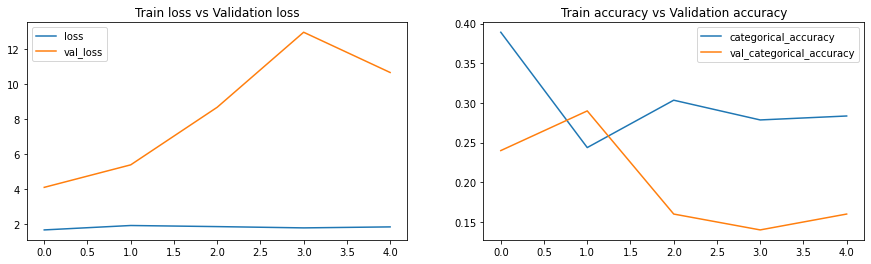

Max. Training Accuracy 0.3891402781009674
Max. Validaiton Accuracy 0.28999999165534973


In [ ]:
plotModelHistory(model1_history)

##Model-2: 
## The architcture is same with Model-1 with Frames-30, Epocs-30 and batch size =32

In [ ]:
n_frames = 30
num_epochs = 30
batch_size = 32

img_tensor = getImgTensor(n_frames)
train_generator = generator(train_path, train_doc, batch_size, img_tensor)
val_generator = generator(val_path, val_doc, batch_size, img_tensor)

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
    
inputShape = (len(img_tensor[0]), img_tensor[1], img_tensor[2], img_tensor[3])

model2 = Sequential([
    Conv3D(16, make3dFilter(5), activation='relu', input_shape=inputShape),
    MaxPooling3D(make3dFilter(2), padding='same'),
    BatchNormalization(),

    Conv3D(32, make3dFilter(3), activation='relu'),
    MaxPooling3D(pool_size=(1,2,2), padding='same'),
    BatchNormalization(),

    Conv3D(64, make3dFilter(3), activation='relu'),
    MaxPooling3D(pool_size=(1,2,2), padding='same'),
    BatchNormalization(),

    Flatten(),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.25),

    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.25),

    Dense(5, activation='softmax')
], name="conv_3d2")
model2.compile(optimizer=optimizers.Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model2.summary())


Model: "conv_3d2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_3 (Conv3D)           (None, 26, 96, 96, 16)    6016      
                                                                 
 max_pooling3d_3 (MaxPooling  (None, 13, 48, 48, 16)   0         
 3D)                                                             
                                                                 
 batch_normalization_5 (Batc  (None, 13, 48, 48, 16)   64        
 hNormalization)                                                 
                                                                 
 conv3d_4 (Conv3D)           (None, 11, 46, 46, 32)    13856     
                                                                 
 max_pooling3d_4 (MaxPooling  (None, 11, 23, 23, 32)   0         
 3D)                                                             
                                                          

In [ ]:
model2_history = model2.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
            callbacks=callbacks_list, validation_data=val_generator, 
            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /gdrive/MyDrive/Project_data/Project_data/train ; batch size = 32
Epoch 1/30
21/21 [==============================] - 3948s 197s/step - loss: 1.5935 - categorical_accuracy: 0.4299 - val_loss: 17.4796 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 2/30
21/21 [==============================] - 206s 10s/step - loss: 1.0669 - categorical_accuracy: 0.5983 - val_loss: 8.7028 - val_categorical_accuracy: 0.1250 - lr: 0.0010
Epoch 3/30
21/21 [==============================] - 160s 8s/step - loss: 0.8923 - categorical_accuracy: 0.6487 - val_loss: 4.0917 - val_categorical_accuracy: 0.1875 - lr: 0.0010
Epoch 4/30
21/21 [==============================] - 112s 6s/step - loss: 0.9709 - categorical_accuracy: 0.6216 - val_loss: 4.6996 - val_categorical_accuracy: 0.0625 - lr: 0.0010
Epoch 5/30
21/21 [==============================] - 96s 5s/step - loss: 1.1023 - categorical_accuracy: 0.5546 - val_loss: 5.0735 - val_categorical_accuracy: 0.2500 - lr: 0.0010
Epoch 6/30
21/21 [=======

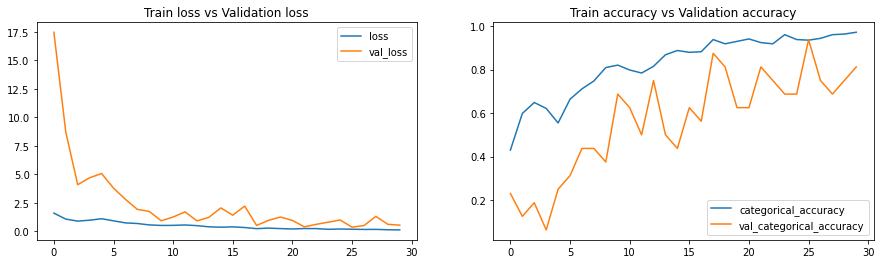

Max. Training Accuracy 0.9719887971878052
Max. Validation Accuracy 0.9375


In [ ]:
plotModelHistory(model2_history)

# The above model is very good accuracy point of view. But the parameters are very high .So it requires lot of computational time.

## Model 3:  
###Using same filter of (3,3,3)
###Frames-16, Epocs-20,batch size =10

In [ ]:
n_frames = 16
num_epochs = 20
batch_size = 10

img_tensor = getImgTensor(n_frames)
train_generator = generator(train_path, train_doc, batch_size, img_tensor)
val_generator = generator(val_path, val_doc, batch_size, img_tensor)

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
    
inputShape = (len(img_tensor[0]), img_tensor[1], img_tensor[2], img_tensor[3])

model3 = Sequential([
    Conv3D(16, make3dFilter(3), padding='same', activation='relu', input_shape=inputShape),
    MaxPooling3D(make3dFilter(2), padding='same'),
    BatchNormalization(),

    Conv3D(32, make3dFilter(3), padding='same', activation='relu'),
    MaxPooling3D(pool_size=(2), padding='same'),
    BatchNormalization(),

    Conv3D(64, make3dFilter(3), padding='same', activation='relu'),
    MaxPooling3D(pool_size=(2), padding='same'),
    BatchNormalization(),

    Flatten(),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.25),

    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.25),

    Dense(5, activation='softmax')
], name="conv_3d3")
model3.compile(optimizer=optimizers.Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model3.summary())

model3_history = model3.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
            callbacks=callbacks_list, validation_data=val_generator, 
            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Model: "conv_3d3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_3 (Conv3D)           (None, 16, 100, 100, 16)  1312      
                                                                 
 max_pooling3d_3 (MaxPooling  (None, 8, 50, 50, 16)    0         
 3D)                                                             
                                                                 
 batch_normalization_5 (Batc  (None, 8, 50, 50, 16)    64        
 hNormalization)                                                 
                                                                 
 conv3d_4 (Conv3D)           (None, 8, 50, 50, 32)     13856     
                                                                 
 max_pooling3d_4 (MaxPooling  (None, 4, 25, 25, 32)    0         
 3D)                                                             
                                                          

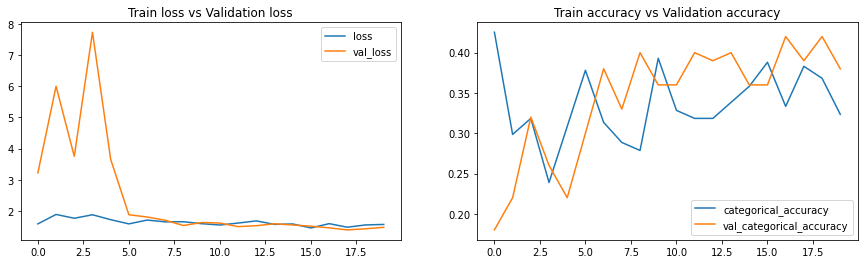

Max. Training Accuracy 0.42533937096595764
Max. Validaiton Accuracy 0.41999998688697815


In [ ]:
plotModelHistory(model3_history)

## Model 4: 
###Frames=30, Epoch = 30,Batch size = 32

In [ ]:
n_frames = 30
num_epochs = 30
batch_size = 32

img_tensor = getImgTensor(n_frames)
train_generator = generator(train_path, train_doc, batch_size, img_tensor)
val_generator = generator(val_path, val_doc, batch_size, img_tensor)

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
    
inputShape = (len(img_tensor[0]), img_tensor[1], img_tensor[2], img_tensor[3])

model4 = Sequential([
    Conv3D(16, make3dFilter(3), padding='same', activation='relu', input_shape=inputShape),
    MaxPooling3D(make3dFilter(2), padding='same'),
    BatchNormalization(),

    Conv3D(32, make3dFilter(3), padding='same', activation='relu'),
    MaxPooling3D(pool_size=(2), padding='same'),
    BatchNormalization(),

    Conv3D(64, make3dFilter(3), padding='same', activation='relu'),
    MaxPooling3D(pool_size=(2), padding='same'),
    BatchNormalization(),

    Conv3D(128, make3dFilter(3), padding='same', activation='relu'),
    MaxPooling3D(pool_size=(2), padding='same'),
    BatchNormalization(),

    Flatten(),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.25),

    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.25),

    Dense(5, activation='softmax')
], name="conv_3d4")
model4.compile(optimizer=optimizers.Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model4.summary())



Model: "conv_3d4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_10 (Conv3D)          (None, 30, 100, 100, 16)  1312      
                                                                 
 max_pooling3d_10 (MaxPoolin  (None, 15, 50, 50, 16)   0         
 g3D)                                                            
                                                                 
 batch_normalization_16 (Bat  (None, 15, 50, 50, 16)   64        
 chNormalization)                                                
                                                                 
 conv3d_11 (Conv3D)          (None, 15, 50, 50, 32)    13856     
                                                                 
 max_pooling3d_11 (MaxPoolin  (None, 8, 25, 25, 32)    0         
 g3D)                                                            
                                                          

In [ ]:
model4_history = model4.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
            callbacks=callbacks_list, validation_data=val_generator, 
            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /gdrive/MyDrive/Project_data/Project_data/train ; batch size = 32
Epoch 1/30
21/21 [==============================] - 4367s 218s/step - loss: 1.5878 - categorical_accuracy: 0.4419 - val_loss: 1.7485 - val_categorical_accuracy: 0.1600 - lr: 0.0010
Epoch 2/30
21/21 [==============================] - 188s 9s/step - loss: 0.9892 - categorical_accuracy: 0.6232 - val_loss: 1.8282 - val_categorical_accuracy: 0.2500 - lr: 0.0010
Epoch 3/30
21/21 [==============================] - 130s 6s/step - loss: 0.8765 - categorical_accuracy: 0.6815 - val_loss: 3.0034 - val_categorical_accuracy: 0.2500 - lr: 0.0010
Epoch 4/30
21/21 [==============================] - 99s 5s/step - loss: 0.8369 - categorical_accuracy: 0.6867 - val_loss: 2.1616 - val_categorical_accuracy: 0.4375 - lr: 0.0010
Epoch 5/30
21/21 [==============================] - ETA: 0s - loss: 0.7642 - categorical_accuracy: 0.7115
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
21/21 [===============

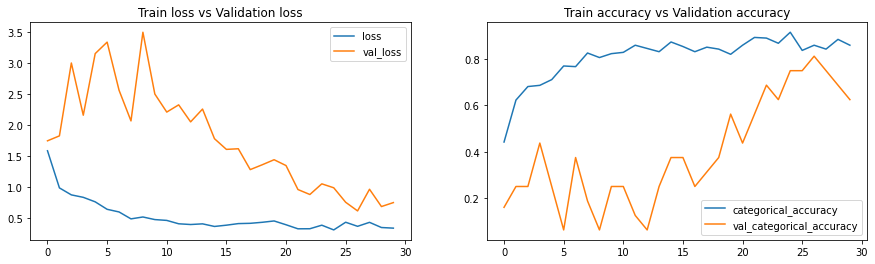

Max. Training Accuracy 0.9159663915634155
Max. Validaiton Accuracy 0.8125


In [ ]:
plotModelHistory(model4_history)

## Model 5: 
### reduced kernel to (2,2,2), switching Batch Normalization before MaxPooling.
### Frames-30, Epocs-20, Batch size-30

In [ ]:
n_frames = 30
num_epochs = 20
batch_size = 30

img_tensor = getImgTensor(n_frames)
train_generator = generator(train_path, train_doc, batch_size, img_tensor)
val_generator = generator(val_path, val_doc, batch_size, img_tensor)

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
    
inputShape = (len(img_tensor[0]), img_tensor[1], img_tensor[2], img_tensor[3])

model5 = Sequential([
    Conv3D(16, make3dFilter(2), padding='same', activation='relu', input_shape=inputShape),
    BatchNormalization(),
    MaxPooling3D(make3dFilter(2)),

    Conv3D(32, make3dFilter(2), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling3D(pool_size=(2)),

    Conv3D(64, make3dFilter(2), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling3D(pool_size=(2)),

    Conv3D(128, make3dFilter(2), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling3D(pool_size=(2)),

    Flatten(),
    Dense(256, activation='relu'),
    # BatchNormalization(),
    # Dropout(0.3),

    Dense(128, activation='relu'),
    # BatchNormalization(),
    # Dropout(0.2),

    Dense(5, activation='softmax')
], name="conv_3d5")
model5.compile(optimizer=optimizers.Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model5.summary())

model5_history = model5.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
            callbacks=callbacks_list, validation_data=val_generator, 
            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Model: "conv_3d5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_14 (Conv3D)          (None, 30, 100, 100, 16)  400       
                                                                 
 batch_normalization_32 (Bat  (None, 30, 100, 100, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_14 (MaxPoolin  (None, 15, 50, 50, 16)   0         
 g3D)                                                            
                                                                 
 conv3d_15 (Conv3D)          (None, 15, 50, 50, 32)    4128      
                                                                 
 batch_normalization_33 (Bat  (None, 15, 50, 50, 32)   128       
 chNormalization)                                                
                                                          

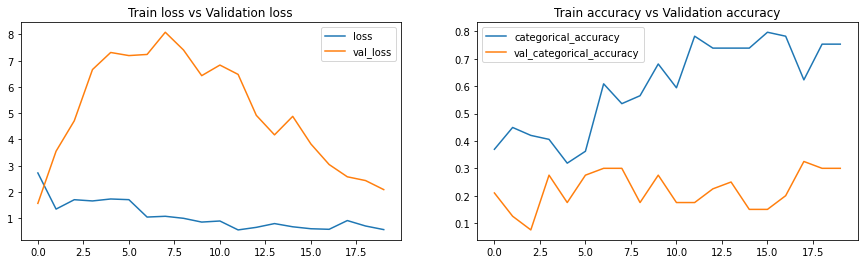

Max. Training Accuracy 0.7971014380455017
Max. Validaiton Accuracy 0.32499998807907104


In [ ]:
plotModelHistory(model5_history)

## Model 6: 
###Switching Model architecture to Conv2D+LSTM

###Frames = 16,Epochs = 20,Batch_size = 20

In [ ]:
n_frames = 16
num_epochs = 20
batch_size = 20

img_tensor = getImgTensor(n_frames)
train_generator = generator(train_path, train_doc, batch_size, img_tensor)
val_generator = generator(val_path, val_doc, batch_size, img_tensor)

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
    
inputShape = (len(img_tensor[0]), img_tensor[1], img_tensor[2], img_tensor[3])

model6 = Sequential([
    TimeDistributed(Conv2D(16, make2dFilter(3), padding='same', activation='relu'), input_shape=inputShape),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D(make2dFilter(2))),

    TimeDistributed(Conv2D(32, make2dFilter(3), padding='same', activation='relu')),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D(make2dFilter(2))),

    TimeDistributed(Conv2D(64, make2dFilter(3), padding='same', activation='relu')),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D(make2dFilter(2))),

    TimeDistributed(Conv2D(128, make2dFilter(3), padding='same', activation='relu')),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D(make2dFilter(2))),

    TimeDistributed(Conv2D(256, make2dFilter(3), padding='same', activation='relu')),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D(make2dFilter(2))),

    TimeDistributed(Flatten()),
    LSTM(256),
    Dropout(0.2),

    Dense(256, activation='relu'),
    Dropout(0.2),

    Dense(5, activation='softmax')
], name="conv_2d_lstm")
model6.compile(optimizer=optimizers.Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model6.summary())


Model: "conv_2d_lstm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_16 (TimeDi  (None, 16, 100, 100, 16)  448      
 stributed)                                                      
                                                                 
 time_distributed_17 (TimeDi  (None, 16, 100, 100, 16)  64       
 stributed)                                                      
                                                                 
 time_distributed_18 (TimeDi  (None, 16, 50, 50, 16)   0         
 stributed)                                                      
                                                                 
 time_distributed_19 (TimeDi  (None, 16, 50, 50, 32)   4640      
 stributed)                                                      
                                                                 
 time_distributed_20 (TimeDi  (None, 16, 50, 50, 32)  

In [ ]:

model6_history = model6.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
            callbacks=callbacks_list, validation_data=val_generator, 
            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /gdrive/MyDrive/Project_data/Project_data/train ; batch size = 20
Epoch 1/20
34/34 [==============================] - 5321s 161s/step - loss: 1.3539 - categorical_accuracy: 0.3922 - val_loss: 1.5627 - val_categorical_accuracy: 0.2800 - lr: 0.0010
Epoch 2/20
34/34 [==============================] - 36s 1s/step - loss: 1.3152 - categorical_accuracy: 0.4412 - val_loss: 3.2172 - val_categorical_accuracy: 0.1600 - lr: 0.0010
Epoch 3/20
34/34 [==============================] - 28s 835ms/step - loss: 1.6540 - categorical_accuracy: 0.2745 - val_loss: 1.9286 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 4/20
34/34 [==============================] - 28s 851ms/step - loss: 1.5287 - categorical_accuracy: 0.3725 - val_loss: 1.7043 - val_categorical_accuracy: 0.2400 - lr: 0.0010
Epoch 5/20
34/34 [==============================] - ETA: 0s - loss: 1.4552 - categorical_accuracy: 0.3137
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
34/34 [===========

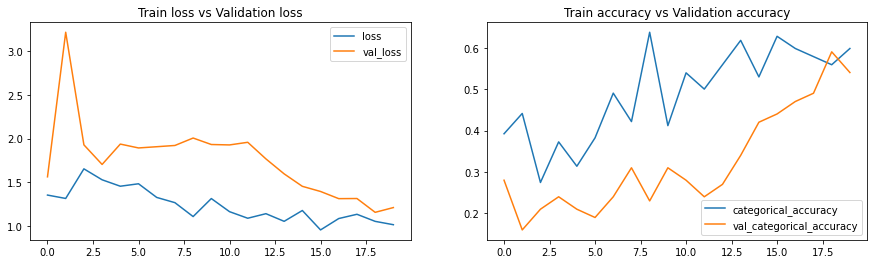

Max. Training Accuracy 0.6372548937797546
Max. Validaiton Accuracy 0.5899999737739563


In [ ]:
plotModelHistory(model6_history)

## Model 7: 

###Switching Model architecture to Conv2D+LSTM

###Frames = 30,Epochs = 30,Batch_size = 20

In [ ]:
n_frames = 30
num_epochs = 30
batch_size = 20

img_tensor = getImgTensor(n_frames)
train_generator = generator(train_path, train_doc, batch_size, img_tensor)
val_generator = generator(val_path, val_doc, batch_size, img_tensor)

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
    
inputShape = (len(img_tensor[0]), img_tensor[1], img_tensor[2], img_tensor[3])

model7 = Sequential([
    TimeDistributed(Conv2D(16, make2dFilter(3), padding='same', activation='relu'), input_shape=inputShape),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D(make2dFilter(2))),

    TimeDistributed(Conv2D(32, make2dFilter(3), padding='same', activation='relu')),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D(make2dFilter(2))),

    TimeDistributed(Conv2D(64, make2dFilter(3), padding='same', activation='relu')),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D(make2dFilter(2))),

    TimeDistributed(Conv2D(128, make2dFilter(3), padding='same', activation='relu')),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D(make2dFilter(2))),

    TimeDistributed(Conv2D(256, make2dFilter(3), padding='same', activation='relu')),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D(make2dFilter(2))),

    TimeDistributed(Flatten()),
    LSTM(256),
    Dropout(0.2),

    Dense(256, activation='relu'),
    Dropout(0.2),

    Dense(5, activation='softmax')
], name="conv_2d_lstm")
model7.compile(optimizer=optimizers.Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model7.summary())


Model: "conv_2d_lstm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 30, 100, 100, 16)  448      
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 30, 100, 100, 16)  64       
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 30, 50, 50, 16)   0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 30, 50, 50, 32)   4640      
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 30, 50, 50, 32)  

In [ ]:
model7_history = model7.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
            callbacks=callbacks_list, validation_data=val_generator, 
            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /gdrive/MyDrive/Project_data/Project_data/train ; batch size = 20
Epoch 1/30
34/34 [==============================] - 179s 5s/step - loss: 1.3418 - categorical_accuracy: 0.4404 - val_loss: 1.9696 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 2/30
34/34 [==============================] - 51s 2s/step - loss: 1.4681 - categorical_accuracy: 0.3922 - val_loss: 1.7745 - val_categorical_accuracy: 0.1900 - lr: 0.0010
Epoch 3/30
34/34 [==============================] - 55s 2s/step - loss: 1.4120 - categorical_accuracy: 0.3922 - val_loss: 2.0332 - val_categorical_accuracy: 0.2500 - lr: 0.0010
Epoch 4/30
34/34 [==============================] - 52s 2s/step - loss: 1.5100 - categorical_accuracy: 0.3627 - val_loss: 2.1217 - val_categorical_accuracy: 0.1600 - lr: 0.0010
Epoch 5/30
34/34 [==============================] - 54s 2s/step - loss: 1.4338 - categorical_accuracy: 0.4020 - val_loss: 1.9239 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 6/30
34/34 [===============

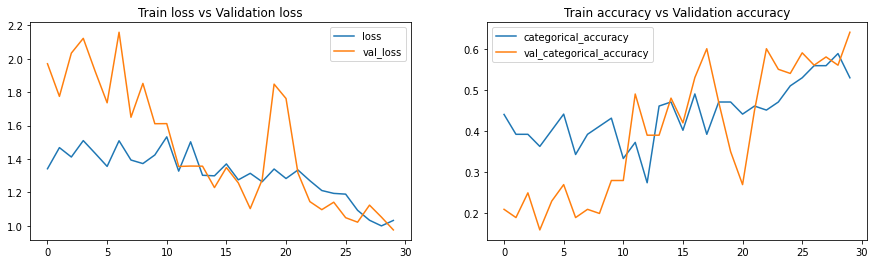

Max. Training Accuracy 0.5882353186607361
Max. Validaiton Accuracy 0.6399999856948853


In [ ]:
plotModelHistory(model7_history)



## Model 8: 

###Switching Model architecture to Conv2D+LSTM

###Frames = 30,Epochs = 30,Batch_size = 30

In [ ]:
n_frames = 30
num_epochs = 30
batch_size = 30

img_tensor = getImgTensor(n_frames)
train_generator = generator(train_path, train_doc, batch_size, img_tensor)
val_generator = generator(val_path, val_doc, batch_size, img_tensor)

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
    
inputShape = (len(img_tensor[0]), img_tensor[1], img_tensor[2], img_tensor[3])

model8= Sequential([
    TimeDistributed(Conv2D(16, make2dFilter(3), padding='same', activation='relu'), input_shape=inputShape),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D(make2dFilter(2))),

    TimeDistributed(Conv2D(32, make2dFilter(3), padding='same', activation='relu')),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D(make2dFilter(2))),

    TimeDistributed(Conv2D(64, make2dFilter(3), padding='same', activation='relu')),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D(make2dFilter(2))),

    TimeDistributed(Conv2D(128, make2dFilter(3), padding='same', activation='relu')),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D(make2dFilter(2))),

    TimeDistributed(Conv2D(256, make2dFilter(3), padding='same', activation='relu')),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D(make2dFilter(2))),

    TimeDistributed(Flatten()),
    LSTM(256),
    Dropout(0.2),

    Dense(256, activation='relu'),
    Dropout(0.2),

    Dense(5, activation='softmax')
], name="conv_2d_lstm")
model8.compile(optimizer=optimizers.Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model8.summary())


Model: "conv_2d_lstm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_16 (TimeDi  (None, 30, 100, 100, 16)  448      
 stributed)                                                      
                                                                 
 time_distributed_17 (TimeDi  (None, 30, 100, 100, 16)  64       
 stributed)                                                      
                                                                 
 time_distributed_18 (TimeDi  (None, 30, 50, 50, 16)   0         
 stributed)                                                      
                                                                 
 time_distributed_19 (TimeDi  (None, 30, 50, 50, 32)   4640      
 stributed)                                                      
                                                                 
 time_distributed_20 (TimeDi  (None, 30, 50, 50, 32)  

In [ ]:
model8_history = model8.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
            callbacks=callbacks_list, validation_data=val_generator, 
            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /gdrive/MyDrive/Project_data/Project_data/train ; batch size = 30
Epoch 1/30
23/23 [==============================] - 172s 8s/step - loss: 1.3435 - categorical_accuracy: 0.4193 - val_loss: 1.8215 - val_categorical_accuracy: 0.1900 - lr: 0.0010
Epoch 2/30
23/23 [==============================] - 27s 1s/step - loss: 1.6362 - categorical_accuracy: 0.3478 - val_loss: 2.2348 - val_categorical_accuracy: 0.2250 - lr: 0.0010
Epoch 3/30
23/23 [==============================] - 28s 1s/step - loss: 1.6725 - categorical_accuracy: 0.2319 - val_loss: 2.0284 - val_categorical_accuracy: 0.2000 - lr: 0.0010
Epoch 4/30
23/23 [==============================] - 28s 1s/step - loss: 1.5387 - categorical_accuracy: 0.3333 - val_loss: 1.7888 - val_categorical_accuracy: 0.2750 - lr: 0.0010
Epoch 5/30
23/23 [==============================] - 27s 1s/step - loss: 1.6666 - categorical_accuracy: 0.3043 - val_loss: 2.5645 - val_categorical_accuracy: 0.2500 - lr: 0.0010
Epoch 6/30
23/23 [===============

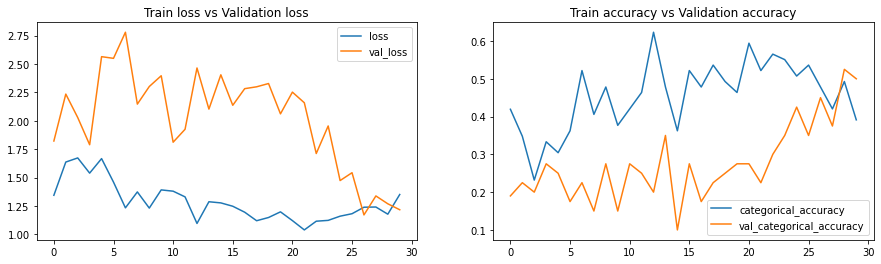

Max. Training Accuracy 0.6231883764266968
Max. Validaiton Accuracy 0.5249999761581421


In [ ]:
plotModelHistory(model8_history)


#Model-9: 
###Switching Model architecture to Conv2D+GRU
######Frames = 30,Epochs = 30,Batch_size = 20

In [ ]:
n_frames = 30
num_epochs = 30
batch_size = 20

img_tensor = getImgTensor(n_frames)
train_generator = generator(train_path, train_doc, batch_size, img_tensor)
val_generator = generator(val_path, val_doc, batch_size, img_tensor)

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
    
inputShape = (len(img_tensor[0]), img_tensor[1], img_tensor[2], img_tensor[3])

model9= Sequential([
    TimeDistributed(Conv2D(16, make2dFilter(3), padding='same', activation='relu'), input_shape=inputShape),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D(make2dFilter(2))),

    TimeDistributed(Conv2D(32, make2dFilter(3), padding='same', activation='relu')),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D(make2dFilter(2))),

    TimeDistributed(Conv2D(64, make2dFilter(3), padding='same', activation='relu')),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D(make2dFilter(2))),

    TimeDistributed(Conv2D(128, make2dFilter(3), padding='same', activation='relu')),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D(make2dFilter(2))),

    TimeDistributed(Conv2D(256, make2dFilter(3), padding='same', activation='relu')),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D(make2dFilter(2))),

    TimeDistributed(Flatten()),
    GRU(256),
    Dropout(0.2),

    Dense(256, activation='relu'),
    Dropout(0.2),

    Dense(5, activation='softmax')
], name="conv_2d_gru")
model9.compile(optimizer=optimizers.Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model9.summary())


Model: "conv_2d_gru"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_16 (TimeDi  (None, 30, 100, 100, 16)  448      
 stributed)                                                      
                                                                 
 time_distributed_17 (TimeDi  (None, 30, 100, 100, 16)  64       
 stributed)                                                      
                                                                 
 time_distributed_18 (TimeDi  (None, 30, 50, 50, 16)   0         
 stributed)                                                      
                                                                 
 time_distributed_19 (TimeDi  (None, 30, 50, 50, 32)   4640      
 stributed)                                                      
                                                                 
 time_distributed_20 (TimeDi  (None, 30, 50, 50, 32)   

In [ ]:
model9_history = model9.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
            callbacks=callbacks_list, validation_data=val_generator, 
            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /gdrive/MyDrive/Project_data/Project_data/train ; batch size = 20
Epoch 1/30
34/34 [==============================] - 179s 5s/step - loss: 1.3116 - categorical_accuracy: 0.4284 - val_loss: 2.2473 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 2/30
34/34 [==============================] - 53s 2s/step - loss: 1.5256 - categorical_accuracy: 0.4216 - val_loss: 3.8456 - val_categorical_accuracy: 0.1800 - lr: 0.0010
Epoch 3/30
34/34 [==============================] - 54s 2s/step - loss: 1.5880 - categorical_accuracy: 0.3431 - val_loss: 3.1817 - val_categorical_accuracy: 0.1700 - lr: 0.0010
Epoch 4/30
34/34 [==============================] - 50s 2s/step - loss: 1.4697 - categorical_accuracy: 0.3824 - val_loss: 2.7578 - val_categorical_accuracy: 0.2000 - lr: 0.0010
Epoch 5/30
34/34 [==============================] - ETA: 0s - loss: 1.4479 - categorical_accuracy: 0.4216
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
34/34 [====================

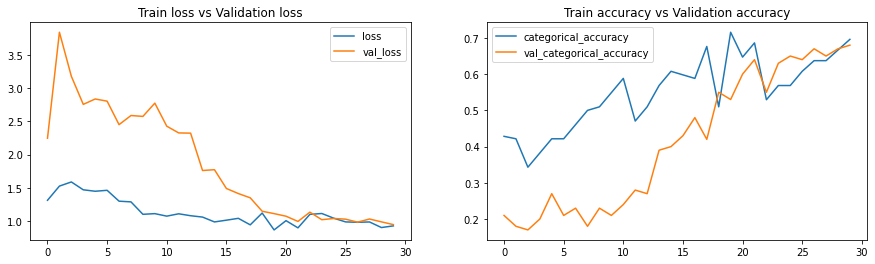

Max. Training Accuracy 0.7156862616539001
Max. Validaiton Accuracy 0.6800000071525574


In [ ]:
plotModelHistory(model9_history)

#Consolidated Final Models

# After doing all the experiments, we finalized Model 9 - CNN+GRU, which performed well.
__Reason:__

__ (Training Accuracy : 72%, Validation Accuracy : 68%)

__ Number of Parameters(2,428,000)

__ No overfitting present.So very stable model

# Final Model

In [24]:
n_frames = 30
num_epochs = 30
batch_size = 20

img_tensor = getImgTensor(n_frames)
train_generator = generator(train_path, train_doc, batch_size, img_tensor)
val_generator = generator(val_path, val_doc, batch_size, img_tensor)

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
    
inputShape = (len(img_tensor[0]), img_tensor[1], img_tensor[2], img_tensor[3])

model_final= Sequential([
    TimeDistributed(Conv2D(16, make2dFilter(3), padding='same', activation='relu'), input_shape=inputShape),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D(make2dFilter(2))),

    TimeDistributed(Conv2D(32, make2dFilter(3), padding='same', activation='relu')),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D(make2dFilter(2))),

    TimeDistributed(Conv2D(64, make2dFilter(3), padding='same', activation='relu')),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D(make2dFilter(2))),

    TimeDistributed(Conv2D(128, make2dFilter(3), padding='same', activation='relu')),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D(make2dFilter(2))),

    TimeDistributed(Conv2D(256, make2dFilter(3), padding='same', activation='relu')),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D(make2dFilter(2))),

    TimeDistributed(Flatten()),
    GRU(256),
    Dropout(0.2),

    Dense(256, activation='relu'),
    Dropout(0.2),

    Dense(5, activation='softmax')
], name="conv_2d_gru")
model_final.compile(optimizer=optimizers.Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model_final.summary())


Model: "conv_2d_gru"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 30, 100, 100, 16)  448      
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 30, 100, 100, 16)  64       
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 30, 50, 50, 16)   0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 30, 50, 50, 32)   4640      
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 30, 50, 50, 32)   

In [25]:
model_final_history = model_final.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
            callbacks=callbacks_list, validation_data=val_generator, 
            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /gdrive/MyDrive/Project_data/Project_data/train ; batch size = 20
Epoch 1/30
34/34 [==============================] - ETA: 0s - loss: 1.3032 - categorical_accuracy: 0.4796  Source path =  /gdrive/MyDrive/Project_data/Project_data/val ; batch size = 20

Epoch 1: val_loss improved from inf to 1.99874, saving model to model_init_2023-03-2015_57_42.281226/model-00001-1.30318-0.47964-1.99874-0.34000.h5
34/34 [==============================] - 10195s 309s/step - loss: 1.3032 - categorical_accuracy: 0.4796 - val_loss: 1.9987 - val_categorical_accuracy: 0.3400 - lr: 0.0010
Epoch 2/30
34/34 [==============================] - ETA: 0s - loss: 1.5483 - categorical_accuracy: 0.3627
Epoch 2: val_loss did not improve from 1.99874
34/34 [==============================] - 64s 2s/step - loss: 1.5483 - categorical_accuracy: 0.3627 - val_loss: 2.9687 - val_categorical_accuracy: 0.1600 - lr: 0.0010
Epoch 3/30
34/34 [==============================] - ETA: 0s - loss: 1.4959 - categorical_accur

# Loading model

In [30]:
from google.colab import files
files.download("model_final.h5")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>